## Part 4.2: Explore multi-sensor and multi-modality sensor fusion with deep learning

Previously in part4.1, we realized we were actually using only a very small portion of the PAMAP2 dataset. And now we have selected more sensors and modalities. We can use the sensor fusion knowledge we've learned in class


In [1]:
#import the packages that we need
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import itertools
from sklearn import neighbors, metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Import files from drive
from google.colab import drive
drive.mount('/content/drive')
# this might prompt you to authorize and might take a minute
!cp -r "/content/drive/My Drive/PAMAP2_Dataset/WindowSamples" .

Mounted at /content/drive


In [2]:
def loadXy(ID):
  # Default file names
  fileName = 'WindowSamples/subject10'+str(ID)+'_multi.npz'
  # Load data from numpy file
  data = np.load(fileName)
  # first lets see what's in the file
  #for k in data.iterkeys():
  #  print(k)
  # Skip the first column because it's timestamp
  X = data['arr_0'][:,:,1:]
  y = data['arr_1']
  return X, y

def balance_data(X, y):
  X_balanced = np.zeros((0, X.shape[1], X.shape[2])) #note we've changed from X_features to X for simplicity
  y_balanced = np.zeros((0))
  #first let's count how many samples are in each class.
  numClass = len(np.unique(y))
  m_counts = np.zeros((numClass))
  m_labels = np.unique(y)
  for i in range(0, numClass):
    m_counts[i] = int(sum(y==m_labels[i]))
  m_least = int(m_counts.min())
  for i in range(1, numClass): # note we are jumping over class 0 now
    rand_ind = np.random.permutation(int(m_counts[i]))
    m_subind = np.where(y==m_labels[i]) # this is the sub-index of the current class in the whole data file
    m_subind_balanced = m_subind[0][rand_ind[0:m_least]]
    # add the selected samples from the current class to the overall balanced dataset
    X_balanced = np.concatenate( (X_balanced, X[m_subind_balanced,:,:]) )
    y_balanced = np.concatenate( (y_balanced, y[m_subind_balanced]) )
  return X_balanced, y_balanced

def plot_confusion_matrix(cm, class_names):
  """
  You can mostly ignore this function
  Returns a matplotlib figure containing the plotted confusion matrix.
  Args:
  cm (array, shape = [n, n]): a confusion matrix of integer classes
  class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(len(class_names)/2, len(class_names)/2))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  acc = np.sum( cm * np.eye(len(class_names)) ) / np.sum(cm)

  plt.title("CM , acc:"+str(round(acc,4)))
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  #plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.show()
  return figure

def label2categorical(m_labels, numClass):
  m_labels_exp = np.zeros( ( len(m_labels), numClass ) )
  LUT = np.unique(m_labels) # to handel sporadically distributed labels
  for i in range (0, len(m_labels)):
      m_labels_exp[i, np.where(LUT==int(m_labels[i]))] = 1
  return m_labels_exp

In [3]:
X, y = loadXy(1)
X_test, y_test = balance_data(X, y)

print(X_test.shape)
print(y_test.shape)

# Check the activites performed by the subject
print(np.unique(y_test))
numClass = len(np.unique(y_test))

(3048, 200, 18)
(3048,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [4]:
# then we prepare the training data with persons 2-8
X_train = np.zeros((0,200,18)) # (sample, time, channel)
y_train = np.zeros((0))
for ID in range(2,8):
  print('ID: '+str(ID))
  X, y = loadXy(ID)
  X, y = balance_data(X,y)
  X_train = np.concatenate( (X_train, X) )
  y_train = np.concatenate( (y_train, y) )

print(X_train.shape)
print(y_train.shape)

# Check the activites performed by the subjects
print(np.unique(y_train))
numClass = len(np.unique(y_train))

ID: 2
ID: 3
ID: 4
ID: 5
ID: 6
ID: 7
(9093, 200, 18)
(9093,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


**Now let's define a Early Fusion model**

In [5]:
m_input = layers.Input(shape=(200,18))
m_output = layers.Conv1D(filters = 20, kernel_size = (3), padding='same', activation='relu')(m_input)
m_output = layers.MaxPooling1D(pool_size=(3))(m_output)
m_output = layers.BatchNormalization()(m_output)
m_output = layers.Dropout(0.2)(m_output)
m_output = layers.Conv1D( filters = 40, kernel_size = (3), padding='same', activation='relu')(m_output)
m_output = layers.BatchNormalization()(m_output)
m_output = layers.MaxPooling1D(pool_size=(3))(m_output)
m_output = layers.Dropout(0.2)(m_output)
m_output = layers.Conv1D( filters = 80, kernel_size = (3), padding='same', activation='relu')(m_output)
m_output = layers.BatchNormalization()(m_output)
m_output = layers.Dropout(0.2)(m_output)
m_output = layers.Conv1D( filters = 1, kernel_size = (3), padding='same', activation='relu')(m_output)
m_output = layers.Flatten()(m_output)
m_output = layers.Dense(20, activation='relu')(m_output)
m_output = layers.Dropout(0.2)(m_output)
m_output = layers.Dense(numClass, activation='softmax')(m_output)

model_EF = keras.models.Model(inputs = m_input, outputs = m_output)

# optimizer
m_opt = keras.optimizers.Adam()
model_EF.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model_EF.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 18)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 200, 20)             │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 66, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 66, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 66, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 66, 40)              │           2,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 66, 40)              │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 22, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 22, 80)              │           9,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 22, 80)              │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 22, 1)               │             241 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 22)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,733 (57.55 KB)

 Trainable params: 14,453 (56.46 KB)

 Non-trainable params: 280 (1.09 KB)

In [ ]:
# early stopping training code block
epoch = 10000  # now with the patience and early stopping, we can define a abundantly big training epoch
batch = 200

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel.h5', monitor='val_accuracy', mode='max',
                                                   verbose=1,save_weights_only=False,save_best_only=True)
cb_earlystop = tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_accuracy',mode='max',
                                                verbose=1,restore_best_weights=True)

numClass = 12
history = model_EF.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
                       validation_split=0.2, verbose = 2,
                       callbacks=[cb_checkpoint, cb_earlystop]
        )


Epoch 1/10000

Epoch 1: val_accuracy improved from -inf to 0.08301, saving model to bestmodel.h5
37/37 - 6s - loss: 0.6263 - accuracy: 0.0850 - val_loss: 0.6654 - val_accuracy: 0.0830 - 6s/epoch - 151ms/step
Epoch 2/10000

Epoch 2: val_accuracy improved from 0.08301 to 0.15778, saving model to bestmodel.h5
37/37 - 3s - loss: 0.4288 - accuracy: 0.1030 - val_loss: 0.4675 - val_accuracy: 0.1578 - 3s/epoch - 84ms/step
Epoch 3/10000

Epoch 3: val_accuracy did not improve from 0.15778
37/37 - 4s - loss: 0.3432 - accuracy: 0.1230 - val_loss: 0.3483 - val_accuracy: 0.0990 - 4s/epoch - 115ms/step
Epoch 4/10000

Epoch 4: val_accuracy did not improve from 0.15778
37/37 - 3s - loss: 0.3111 - accuracy: 0.1406 - val_loss: 0.3250 - val_accuracy: 0.0929 - 3s/epoch - 86ms/step
Epoch 5/10000

Epoch 5: val_accuracy did not improve from 0.15778
37/37 - 3s - loss: 0.2946 - accuracy: 0.1607 - val_loss: 0.3115 - val_accuracy: 0.0825 - 3s/epoch - 84ms/step
Epoch 6/10000

Epoch 6: val_accuracy did not improve 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


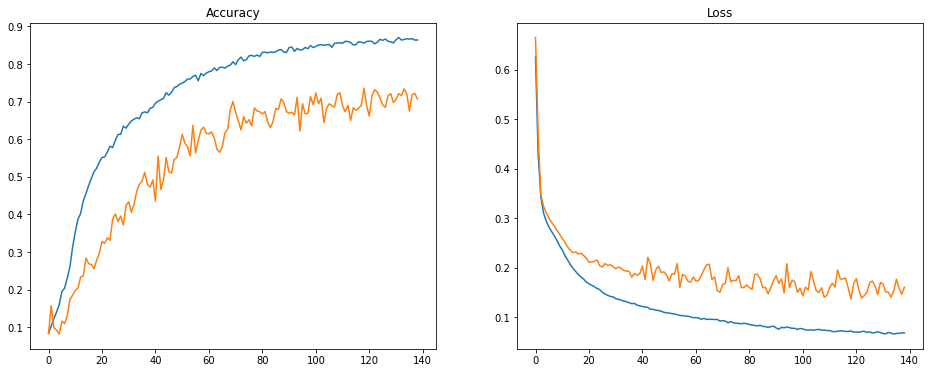

In [ ]:
# history contains the training information about accuracy and loss in every epoch
print(history.history.keys())

figure = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.show()

[[105  91   0  43   0   0   1   2   0   1  11   0]
 [  1  68 134   0   0   0   0   0   0   4  46   1]
 [  0  38 164   0   0   0   0   0   1   0  51   0]
 [  0   0   0  45   0   0 185   8   2   0  14   0]
 [  0   0   0   0 239   0   0   3   1   1  10   0]
 [  0   2   0   0   0 235   0   0   0   5  12   0]
 [  0   0   0   3   0   0 200  13  12   2  23   1]
 [  0   0   0   0   1   1   1 196   0  24  31   0]
 [  0  10   0   4   0   0   2   1 209   3  25   0]
 [  0   0   0   0   0   6   0   2   4 218  24   0]
 [  0  14   1   0   0   0   0   0   0   0 239   0]
 [  0   2   1  23   4   0 105  26  18   7  25  43]]


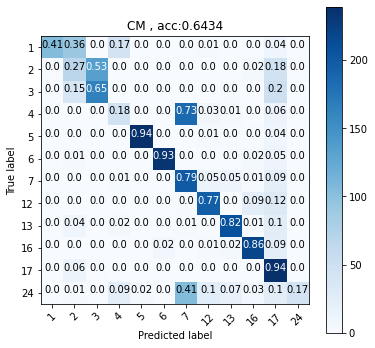

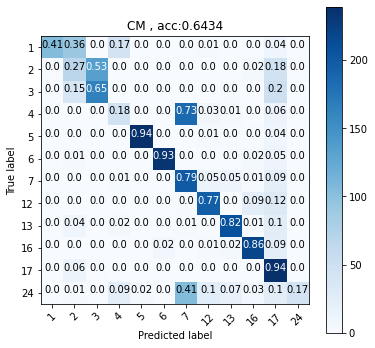

In [ ]:
model_EF.load_weights('bestmodel.h5')

y_predict = model_EF.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
# Convert back from categorical to numerical with np.argmax()
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1))
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))

Now let's use the power of Functional API to build the Shared Filters Hybrid Fusion (SF-HF) method. But instead of using every single channel, I want to try using 3 channels at a time from every sensor, and then the shared filters should take an input of (200, 3).


In [ ]:
shared_filters = keras.models.Sequential([
        layers.Reshape(target_shape=(200,3), input_shape=(200,3,1)),
        layers.Conv1D( filters = 10, kernel_size = 3, padding='same', activation='relu', input_shape=(200,3)),
        layers.MaxPooling1D(pool_size=(3)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv1D( filters = 20, kernel_size = 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=(3)),
        layers.Dropout(0.2),
        layers.Conv1D( filters = 40, kernel_size = 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv1D( filters = 80, kernel_size = 3, padding='same', activation='relu') #80
  ], name = 'shared_filters'
)

# we want to use this summary to see the output dimension of the shared filters
shared_filters.summary()


Model: "shared_filters"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 200, 3)            0         
                                                                 
 conv1d (Conv1D)             (None, 200, 10)           100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 10)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 66, 10)           40        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 66, 10)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 20)         

To crop and select 3 channels at a time from the (200, 18) input, we can use the cropping2D layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Cropping2D

This is like pooling, it's rather an operation without any trainable parameters.


In [ ]:

m_input_1 = layers.Input(shape=(200,18))
m_input_2 = layers.Reshape(target_shape=(200,18,1))(m_input_1)

m_sensor_0 = layers.Cropping2D(cropping=((0,0), (0, 15)))(m_input_2)
m_sensor_1 = layers.Cropping2D(cropping=((0,0), (3, 12)))(m_input_2)
m_sensor_2 = layers.Cropping2D(cropping=((0,0), (6, 9 )))(m_input_2)
m_sensor_3 = layers.Cropping2D(cropping=((0,0), (9, 6 )))(m_input_2)
m_sensor_4 = layers.Cropping2D(cropping=((0,0), (12,3 )))(m_input_2)
m_sensor_5 = layers.Cropping2D(cropping=((0,0), (15,0 )))(m_input_2)

m_sensor_0 = shared_filters(m_sensor_0)
m_sensor_1 = shared_filters(m_sensor_1)
m_sensor_2 = shared_filters(m_sensor_2)
m_sensor_3 = shared_filters(m_sensor_3)
m_sensor_4 = shared_filters(m_sensor_4)
m_sensor_5 = shared_filters(m_sensor_5)

m_output_1 = layers.Concatenate(axis=2)([m_sensor_0, m_sensor_1, m_sensor_2, m_sensor_3, m_sensor_4, m_sensor_5])

m_output_1 = layers.Conv1D(filters = 1, kernel_size = (3), padding='same', activation='relu')(m_output_1)
m_output_1 = layers.Flatten()(m_output_1)
m_output_1 = layers.Dense(20, activation='relu')(m_output_1)
m_output_1 = layers.Dense(numClass, activation='softmax')(m_output_1)

model_HF = keras.models.Model(inputs = m_input_1, outputs = m_output_1, name='model_HF')

# optimizer
m_opt = keras.optimizers.Adam(learning_rate=0.0001)
model_HF.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model_HF.summary()

Model: "model_HF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 18)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 200, 18, 1)   0           ['input_1[0][0]']                
                                                                                                  
 cropping2d (Cropping2D)        (None, 200, 3, 1)    0           ['reshape_1[0][0]']              
                                                                                                  
 cropping2d_1 (Cropping2D)      (None, 200, 3, 1)    0           ['reshape_1[0][0]']              
                                                                                           

First we see the total parameters are significantly less than EF. Also there's a new column: connected to, because of the sharing connections we made. There's an easier way to see it:

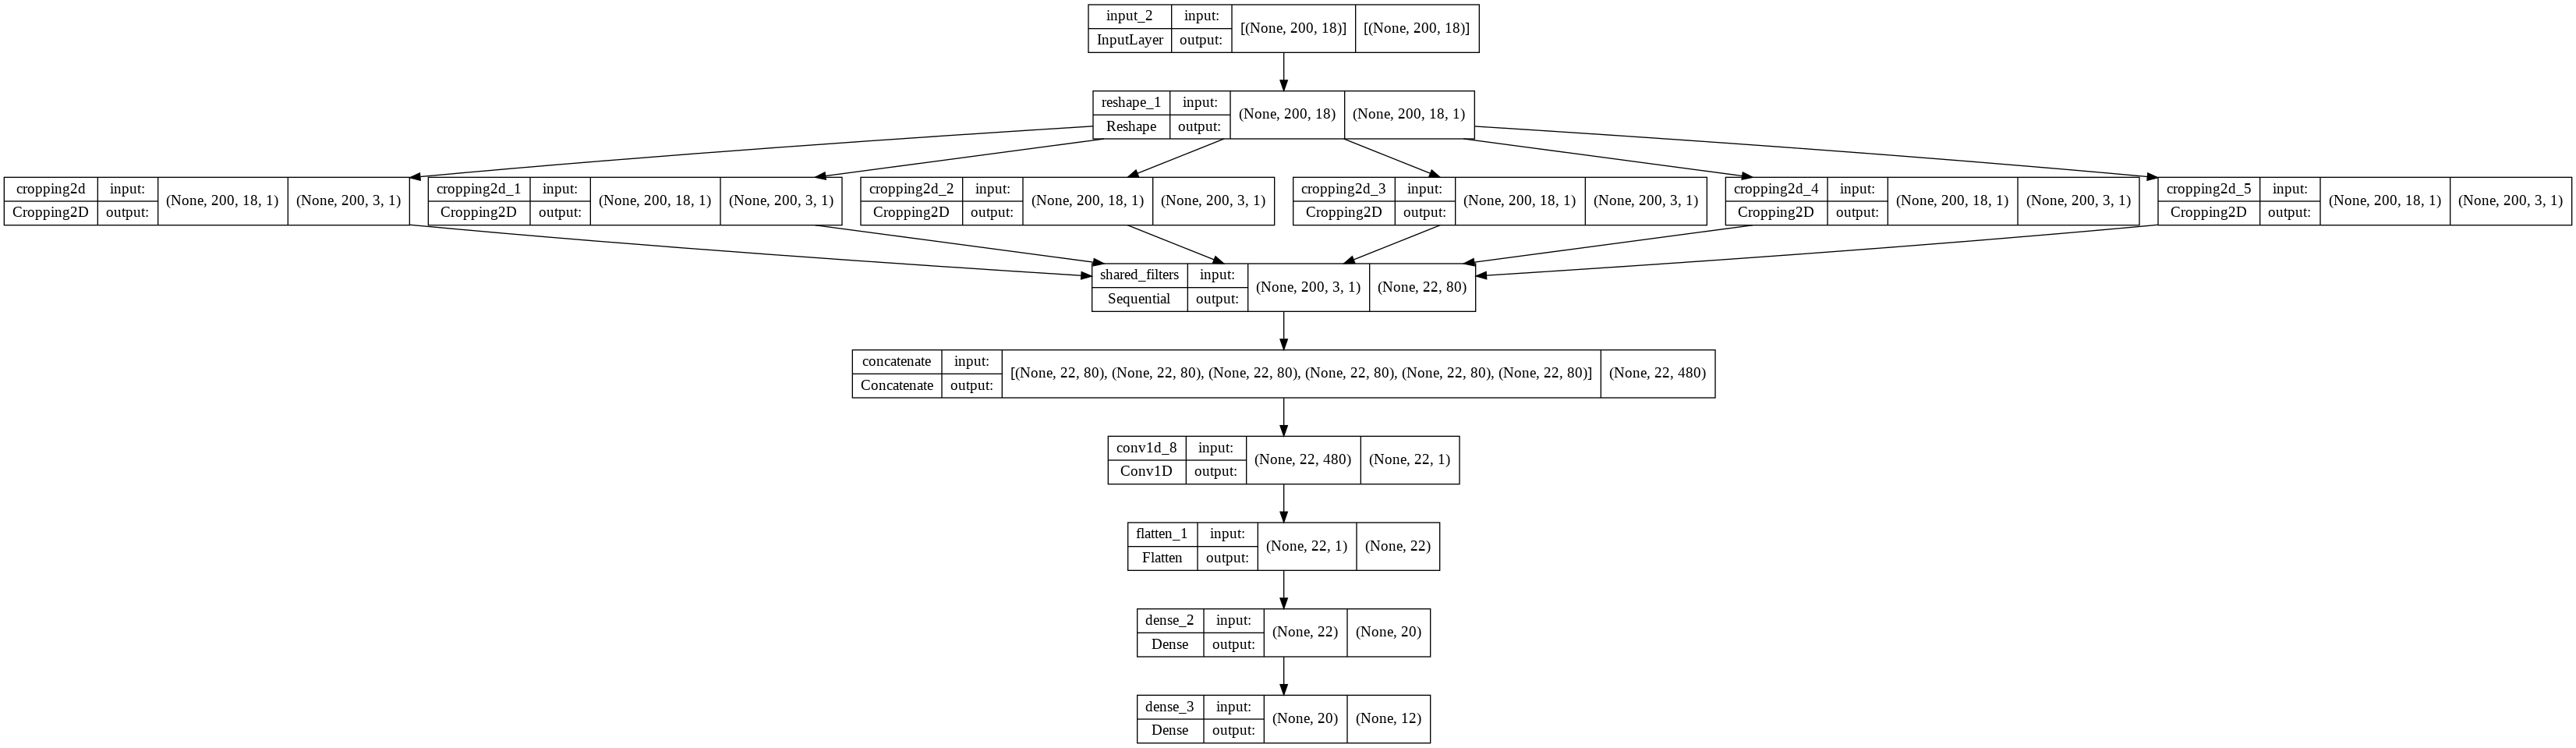

In [ ]:
keras.utils.plot_model(model_HF, show_shapes=True)

In [ ]:
# now let's train it, same process
epoch = 1000
batch = 200
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_HF.h5', monitor='val_accuracy', mode='max',
                                                   verbose=1,save_weights_only=False,save_best_only=True)
cb_earlystop = tf.keras.callbacks.EarlyStopping(patience=50,monitor='val_accuracy',mode='max',
                                                verbose=1,restore_best_weights=True)
history_2 = model_HF.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
                       validation_split=0.2, verbose = 2,
                       callbacks=[cb_checkpoint, cb_earlystop]
        )

Epoch 1/1000

Epoch 1: val_accuracy improved from -inf to 0.07971, saving model to bestmodel_HF.h5
37/37 - 20s - loss: 0.6796 - accuracy: 0.0903 - val_loss: 0.6768 - val_accuracy: 0.0797 - 20s/epoch - 530ms/step
Epoch 2/1000

Epoch 2: val_accuracy did not improve from 0.07971
37/37 - 1s - loss: 0.6544 - accuracy: 0.0977 - val_loss: 0.6454 - val_accuracy: 0.0715 - 928ms/epoch - 25ms/step
Epoch 3/1000

Epoch 3: val_accuracy did not improve from 0.07971
37/37 - 1s - loss: 0.6125 - accuracy: 0.1075 - val_loss: 0.5928 - val_accuracy: 0.0599 - 863ms/epoch - 23ms/step
Epoch 4/1000

Epoch 4: val_accuracy did not improve from 0.07971
37/37 - 1s - loss: 0.5407 - accuracy: 0.1115 - val_loss: 0.5128 - val_accuracy: 0.0528 - 865ms/epoch - 23ms/step
Epoch 5/1000

Epoch 5: val_accuracy did not improve from 0.07971
37/37 - 1s - loss: 0.4470 - accuracy: 0.1152 - val_loss: 0.4227 - val_accuracy: 0.0627 - 846ms/epoch - 23ms/step
Epoch 6/1000

Epoch 6: val_accuracy improved from 0.07971 to 0.11325, saving

You might notice that this smaller model on the contary takes extremely longer time to train per epoch compared with the bigger EF model. This is because the operation of activating the shared filters 6 times is not effectively paralizable. But we can optimize this for example defining 6x shared filters instances and lock their weights together, but this is out of this project scope

[[228   8   0   0   0   0   0   6  11   1   0   0]
 [  1 117   1   0   0   0   0  59  73   1   2   0]
 [  1 113  82   0   0   0   0  55   3   0   0   0]
 [  0  14   0  22   0   0  22 164  32   0   0   0]
 [  0  17   0   0 102   0  23   1 111   0   0   0]
 [ 13   8   0   0   0  20   0   0 200   1  12   0]
 [  0  23   0   0   0   0  82  17 132   0   0   0]
 [  0  28   1   0   0   0   8 200  17   0   0   0]
 [  2  32   0   2   0   0  19 172  27   0   0   0]
 [  7   8   0   0   0   2   1  18  51  85  82   0]
 [  0  65   0   0   0   0   0   0 189   0   0   0]
 [  0  17   0   0  82   2   8   0 140   0   0   5]]


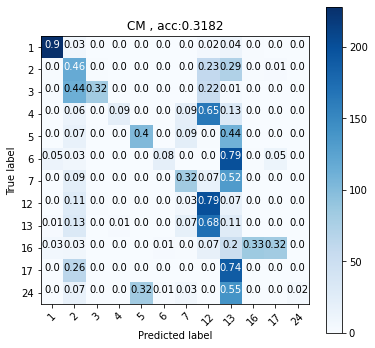

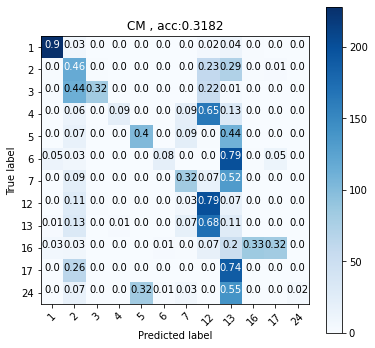

In [ ]:
y_predict = model_HF.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
# Convert back from categorical to numerical with np.argmax()
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1))
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))

# Epilogue

In this part, we've explored the sensor fusion with some quite advanced deep learning techniques. Curiously for my own attempt the SF-HF approach (albeit my customized version) hasn't outperformed the EF approach. This might just be we haven't trained the model enough, or some details in the shared filters need improving.
